In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, LeakyReLU, Activation, UpSampling2D
from keras.layers import BatchNormalization, ReLU
from keras.models import Model, Sequential
from keras.datasets import cifar10
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam


Using TensorFlow backend.


#Loading Dataset CIFAR10

First of all, we load CIFAR10 which is part of the Keras Datasets. 

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## dataset visualization

lets take a look at some of the pictures in the dataset.

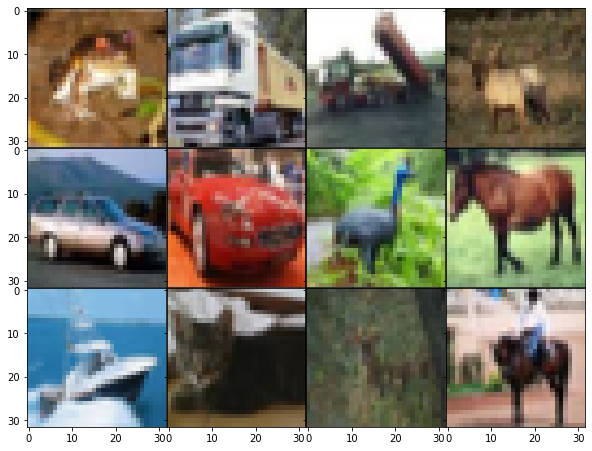

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10, 12))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3,4),
                 axes_pad=0.01,)

for i in range(12):
    grid[i].imshow(x_train[i])

## Data preprocessing


For data preprocessing phase, we changed type of numbers to float for speeding up training of model and normalize data for better results and faster training. 

Then we resized data so that each sample takes (32, 32, 3) shape.

In [ ]:
x_train = np.float32(x_train)
x_test = np.float32(x_test)

x_train = (x_train / 255 - 0.5) * 2
x_test = (x_train / 255 - 0.5) * 2

x_train = np.clip(x_train, -1, 1)
x_test = np.clip(x_test, -1, 1)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (50000, 32, 32, 3), (50000, 1), (10000, 1))

In [ ]:
_, img_height, img_width, num_channels = x_train.shape
img_shape = (img_height, img_width, num_channels)

kernel_size = 5

# Discriminator

At first we define the discriminator part of the network.

In [ ]:
from keras import initializers

noise_shape = (100, )
dim = 4
depth = 1024

init = initializers.RandomNormal(stddev=0.02)

The discriminator consists of all convoloutional layers with LeakyReLU with 0.2 parameter with kernel size 5 and stride 2 and Batch Normalization on every layer and the activation function of the last layer is sigmoid.

In [ ]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)        

# Generator

Then we define the Generator part.

Using the same activation functions as the discriminator exept for the last layer which uses tanh with kernel size 5 and stride 2

In [ ]:
# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=noise_shape, kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 256)        

Now we compile both models above using binary cross entropy and Adam optimizer.

And finally we compile the whole DCGAN.

In [ ]:
from keras.optimizers import Adam

discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])


discriminator.trainable = False

z = Input(shape=noise_shape)
img = generator(z)
decision = discriminator(img)
dcgan = Model(inputs=z, outputs=decision)

dcgan.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

dcgan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


#Training

Noise dim is a 100 dimension vector.

Number of Epochs is 100.

Batch size is 32.

In [ ]:
batch_size = 32
epochs = 100
noise_dim = 100
smooth = 0.1

Now we define a function that generates a n dimentional normal noise.

In [ ]:
def gennoise(batch_size, noise_dim=100): 
    x = np.random.normal(0, 1.0, (batch_size, noise_dim))
    return x

For each epoch, at first we train discriminator with real and fake samples and then train the GAN while freezing the weights of discriminator part.

In [ ]:
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(x_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        x_batch = x_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=x_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = gennoise(batch_size, noise_dim)
        x_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=x_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = dcgan.train_on_batch(x=z, y=real)

    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')


    if e % 20 == 0:
        fig = plt.figure(figsize=(10, 12))
        grid = ImageGrid(fig, 111,
                        nrows_ncols=(10,10),
                        axes_pad=0.01,)
        for i in range(100):
            grid[i].imshow((((generator.predict(gennoise(1))) + 1)* 127).reshape((32,32, 3)).astype(np.uint8))
        plt.show()
        name = 'pic' + str(e) + '.png'
        fig.savefig('gdrive/My Drive/NN/MiniProj3/Result2/final/'+name)


## Loss figures

Now using the vectors we have saved in the last part, we plot the loss figures.

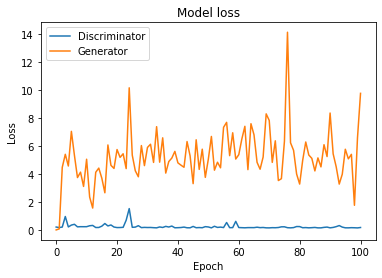

In [ ]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'])
plt.show()

## Final plot

To show the final results, we plot a 10x10 figure of random noise input. 

In [ ]:
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.01,)

for i in range(100):
    pic = (generator.predict(np.random.normal(loc=0, scale=1, size=(1, 100))) + 1) * 127
    grid[i].imshow((pic).reshape(32,32,3).astype(np.uint8))
plt.show()
name = 'pic' + str(e) + '.png'
fig.savefig('gdrive/My Drive/NN/MiniProj3/Result2/final/'+name)
